In [ ]:
from tensorflow import keras
import os
from google.colab import drive
import random as rn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive/')

Mounted at /content/drive/


# **Dataset load**

In [ ]:
out_path = '/content/drive/MyDrive/Ritorti[_Pasco]/project/numpy_data'

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_testing():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels

train_images, train_labels = load_training()
test_images, test_labels = load_testing()

# **Preprocessing**


## Preparing training and test set for benign-malignant classification

In [ ]:
#BENIGN - MALIGNANT
train_zipped = zip(train_images,train_labels)
test_zipped = zip(test_images,test_labels)
train_images_ben_mal,train_labels_ben_mal = [],[]
test_images_ben_mal,test_labels_ben_mal = [],[]

#training
for im,la in train_zipped:
  if la == 1 or la == 3: #benign -> 0
    train_images_ben_mal.append(im)
    train_labels_ben_mal.append(0)
  elif la == 2 or la == 4: #malignant -> 1
    train_images_ben_mal.append(im)
    train_labels_ben_mal.append(1)

#testing
for im,la in test_zipped:
  if la == 1 or la == 3: #benign -> 0
    test_images_ben_mal.append(im)
    test_labels_ben_mal.append(0)
  elif la == 2 or la == 4: #malignant -> 1
    test_images_ben_mal.append(im)
    test_labels_ben_mal.append(1)

train_images_ben_mal = np.array(train_images_ben_mal)
train_labels_ben_mal = np.array(train_labels_ben_mal)
test_images_ben_mal = np.array(test_images_ben_mal)
test_labels_ben_mal = np.array(test_labels_ben_mal)
print(f"Shape training: {train_images_ben_mal.shape}")
print(f"Shape testing: {test_images_ben_mal.shape}")

Shape training: (2676, 150, 150)
Shape testing: (336, 150, 150)


In [ ]:
# Setting of parameters for reproducible results
os.environ["PYTHONHASHSEED"]="0"
np.random.seed(31)
rn.seed(14)
tf.random.set_seed(1234)

## Some of our dataset view

Distribution of classes

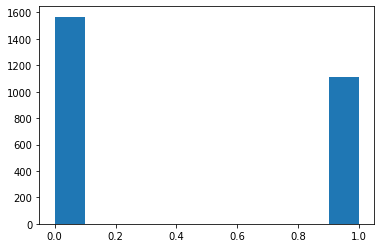

In [ ]:
plt.hist(train_labels_ben_mal)
plt.show()

First image of the training set

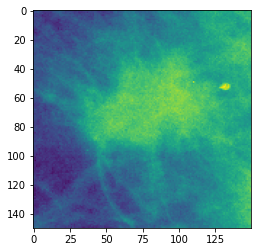

In [ ]:
plt.imshow(train_images_ben_mal[0,:,:])

Check of value range and distribution

uint16


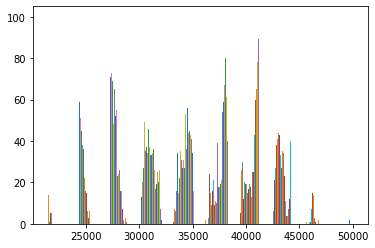

In [ ]:
print(train_images_ben_mal[0].dtype)
plt.hist(train_images_ben_mal[0])
plt.show()

## Conversion from greyscale to color images and normalization

In [ ]:
train_images_ben_mal = np.repeat(train_images_ben_mal[..., np.newaxis], 3, -1)
train_images_ben_mal = train_images_ben_mal.astype('float32') / 65535

test_images_ben_mal = np.repeat(test_images_ben_mal[..., np.newaxis], 3, -1)
test_images_ben_mal = test_images_ben_mal.astype('float32') / 65535

print(train_images_ben_mal.shape)

(2676, 150, 150, 3)


# **Pre-trained network**

In [ ]:
from tensorflow.keras.applications import VGG16, Xception, InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_____________

## Densly-connected network on top of the pre-trained one

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.45))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.45))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               7078400   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [ ]:
#freezing conv_base
conv_base.trainable = False

In [ ]:
from tensorflow.keras import optimizers

BATCH_SIZE = 32
NUM_EPOCHS = 30

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
      train_images_ben_mal,
      train_labels_ben_mal,
      epochs= NUM_EPOCHS,
      batch_size = BATCH_SIZE,
      validation_split = 0.2,
      shuffle = True
      )

Epoch 1/30
67/67 [==============================] - 26s 148ms/step - loss: 2.1035 - acc: 0.5753 - val_loss: 0.7450 - val_acc: 0.6903
Epoch 2/30
67/67 [==============================] - 6s 90ms/step - loss: 0.8309 - acc: 0.6384 - val_loss: 0.5831 - val_acc: 0.6922
Epoch 3/30
67/67 [==============================] - 6s 90ms/step - loss: 0.7966 - acc: 0.6484 - val_loss: 0.5636 - val_acc: 0.6810
Epoch 4/30
67/67 [==============================] - 6s 91ms/step - loss: 0.6973 - acc: 0.6874 - val_loss: 0.6895 - val_acc: 0.6866
Epoch 5/30
67/67 [==============================] - 6s 91ms/step - loss: 0.6252 - acc: 0.7160 - val_loss: 0.6243 - val_acc: 0.6903
Epoch 6/30
67/67 [==============================] - 6s 92ms/step - loss: 0.5927 - acc: 0.7362 - val_loss: 0.5559 - val_acc: 0.7034
Epoch 7/30
67/67 [==============================] - 6s 93ms/step - loss: 0.5757 - acc: 0.7162 - val_loss: 0.5232 - val_acc: 0.6978
Epoch 8/30
67/67 [==============================] - 6s 93ms/step - loss: 0.5626 -

Save the model

In [ ]:
# dir_name ="/content/drive/My Drive/Ritorti[_Pasco]/models"
# if not os.path.exists(dir_name):
#   os.makedirs(dir_name)
# model.save(os.path.join(dir_name,'cnn_pretrained_ben_mal.h5'))

# **Training and validation accuracy-loss diagrams**

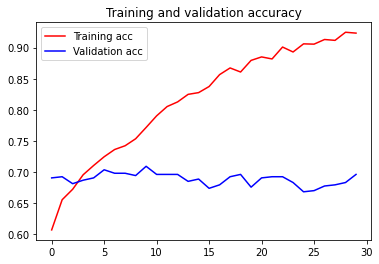

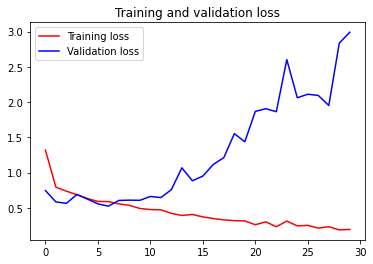

In [ ]:
import matplotlib.pyplot as plt
# dir_img = "/content/drive/My Drive/Ritorti[_Pasco]/plot_images_1"
# if not os.path.exists(dir_img):
#   os.makedirs(dir_img)

acc_1 = history.history['acc']
val_acc_1 = history.history['val_acc']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig(os.path.join(dir_img,"Inception_2layers_accuracy.png"))
plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig(os.path.join(dir_img,"Inception_2layers_loss.png"))

plt.show()

# **Evaluating the model with the test set**

In [ ]:
test_loss, test_acc = model.evaluate(test_images_ben_mal, test_labels_ben_mal)
print('test_acc:', test_acc)

11/11 [==============================] - 1s 104ms/step - loss: 2.7708 - acc: 0.6786
test_acc: 0.6785714030265808


In [ ]:
predictions = model.predict(test_images_ben_mal) # get the output for each sample
predictions = np.round(predictions)
predictions = predictions.astype(int)
unique, counts = np.unique(test_labels_ben_mal, return_counts=True)
print('true',dict(zip(unique, counts)))
unique, counts = np.unique(predictions, return_counts=True)
print('pred',dict(zip(unique, counts)))

true {0: 219, 1: 117}
pred {0: 177, 1: 159}


**We save the predictions in a txt file to use them in the ensable method**

In [ ]:
# import csv
# dir_data_store ="/content/drive/My Drive/Ritorti[_Pasco]/data_store"
# if not os.path.exists(dir_data_store):
#   os.makedirs(dir_data_store)

#np.savetxt(os.path.join(dir_data_store,"predictions_32.csv"), predictions, delimiter=",")

**Evaluation of the model with the following tools:**


1.   Confusion matrix
2.   Accuracy, precision, recall and f1-score
3.   ROC curve



In [ ]:
from sklearn import metrics
metrics.confusion_matrix(test_labels_ben_mal,predictions)

array([[144,  75],
       [ 33,  84]])

In [ ]:
# accuracy: (TP+TN)/(TP+FP+FN+TN): percentage of correctly predicted samples
metrics.accuracy_score(test_labels_ben_mal,predictions)

0.6785714285714286

In [ ]:
# precision: TP/(TP+FP): The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
metrics.precision_score(test_labels_ben_mal,predictions)

0.5283018867924528

In [ ]:
# recall: TP/(TP+FN): The recall is intuitively the ability of the classifier to find all the positive samples.
metrics.recall_score(test_labels_ben_mal,predictions)

0.717948717948718

In [ ]:
# f1-score: 2*(precision*recall)/(precision + recall). The F1-score is the harmonic mean of precision and sensitivity
metrics.f1_score(test_labels_ben_mal,predictions)

0.6086956521739131

In [ ]:
# classification report: Build a text report showing the main classification metrics
print(metrics.classification_report(test_labels_ben_mal,predictions))

              precision    recall  f1-score   support

           0       0.81      0.66      0.73       219
           1       0.53      0.72      0.61       117

    accuracy                           0.68       336
   macro avg       0.67      0.69      0.67       336
weighted avg       0.71      0.68      0.69       336



In [ ]:
fpr,tpr,th = metrics.roc_curve(test_labels_ben_mal,predictions)
roc_auc = metrics.roc_auc_score(test_labels_ben_mal,predictions)

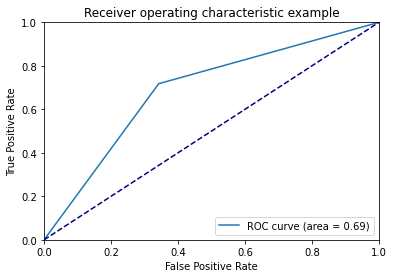

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig(os.path.join(dir_img,"ROC_curve.png"))
plt.show()

# **SUBMISSION CONTEST**

In [ ]:
#preparing private test data
x_test_private = np.load(os.path.join(out_path,'private_test_tensor.npy')) #load private test tensor

x_test_baseline = x_test_private[0::2] 
x_test_abno = x_test_private[1::2] # remove baseline if you don't use it

# normalization and conversion to RGB
x_test_abno = np.repeat(x_test_abno[..., np.newaxis], 3, -1)
x_test_abno = x_test_abno.astype('float32') / 65535

prediction = model.predict(x_test_abno)
prediction = np.round(prediction)
predictions = prediction.astype(int) #probability to integer
output_labels = []
for i in range(len(predictions)):
   output_labels.append(predictions[i][0]) #write on file only the number separated from newline

assert len(output_labels) == 336 # must be of this size!

dir_submission ="/content/drive/My Drive/Ritorti[_Pasco]"

with open(os.path.join(dir_submission,'Submission.csv'),'w') as mf:
  mf.writelines("\n".join(str(i) for i in output_labels) )

In [ ]:
unique, counts = np.unique(output_labels, return_counts=True)
print('pred_private',dict(zip(unique, counts)))

pred_private {0: 169, 1: 167}
